# Nuclear Mass Neural Net

This short tensorflow toy trains a standard neural network to output binding energy based on an input neutron and proton number. The first code block uses a saved model and should stand by itself, but the training stuff is down below.

Also included are a couple of widgets. Be sure to run the first cell first to define some functions, then the widgets should run fine provided you have the environment set up correctly.

In [117]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
from sklearn.externals import joblib
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)

# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# input N,Z return model estimated binding energy
def BE(N, Z):
    # Hard code the data averages
    nucleus=xscaler.transform(np.array([[Z,N]]))
    [[BE]] = yscaler.inverse_transform(model.predict(nucleus,verbose=0))
    return BE

def GenerateMasses():
    
    nuclei=[[0,0]]
    for zi in range(1,120):
        for ni in range(0,160):
            nuclei=np.append(nuclei,xscaler.transform([[zi,ni]]),axis=0)
            
    energies=yscaler.inverse_transform(model.predict(nuclei,verbose=0))
    nuclei = xscaler.inverse_transform(nuclei)
    a_sum=np.sum(nuclei,axis=1)
    return pd.DataFrame({'A':a_sum,'Z':nuclei[:,0],'N':nuclei[:,1],'Energies':energies[:,0]})

def CalcSepEn(Z,A1,A2):
    Nucleus=predicted.loc[lambda predicted: predicted.Z==Z, :]
    Nucleus=Nucleus.loc[(Nucleus['A'] >= A1) & (Nucleus['A'] <= A2)]
    Nucleus['NeutronSeparationEnergies'] = Nucleus['Energies'].diff(+1)
    return Nucleus

# And now to load scaler

xscaler = joblib.load(xscaler_filename)     
yscaler = joblib.load(yscaler_filename)     
 
# load our pretrained model
massmodel = tf.keras.models.load_model('neuralmasses_testing.h5', custom_objects={'R2': R2})

# Generate a massive mass chart
predicted=GenerateMasses()

500/500 [==============================] - 0s 73us/sample - loss: 4.9000e-06 - R2: 1.0000


/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Test Loss: 4.9e-06
Test R2: 1.0


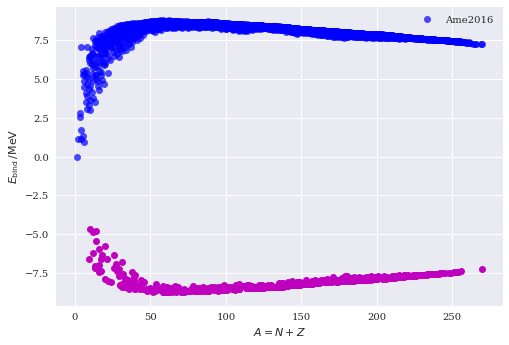

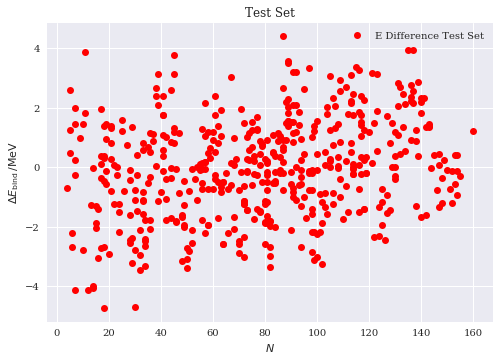

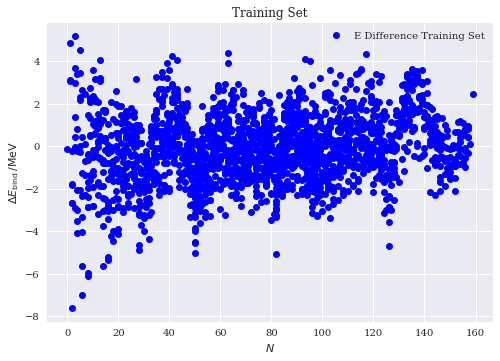

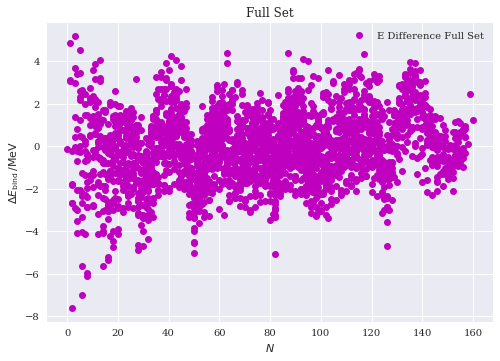

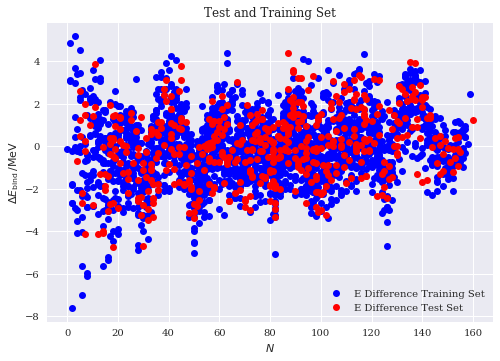

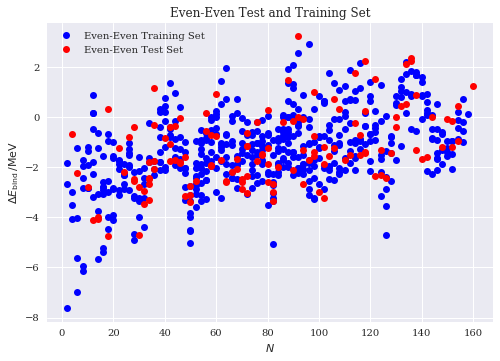

In [119]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)
    
# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']

## All above comes from another notebook

# Build input array
xx = (Z.as_matrix()[:],N.as_matrix()[:])
xx = np.asarray(xx)
xx = xx.T
aa = np.sum(xx,axis=1)
yy = (-1.0*np.asarray(Energies)*aa).reshape(-1, 1)

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

# Scale input

#xscaler = MinMaxScaler()
#xscaler.fit(x_train)

xs_train = xscaler.transform(x_train)
xs_test = xscaler.transform(x_test)
xs_full = xscaler.transform(xx)

#yscaler = MinMaxScaler()
#yscaler.fit(y_train)

ys_train = yscaler.transform(y_train)
ys_test = yscaler.transform(y_test)
ys_full = yscaler.transform(yy)

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, ys_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

testen_out=model.predict(xs_test)
trainen_out=model.predict(xs_train)
fullen_out=model.predict(xs_full)

# Shift back for plotting

x_train = xscaler.inverse_transform(xs_train)
x_test = xscaler.inverse_transform(xs_test)
x_full = xscaler.inverse_transform(xs_full)

trainen_out = yscaler.inverse_transform(trainen_out).T.squeeze()
testen_out = yscaler.inverse_transform(testen_out).T.squeeze()
fullen_out = yscaler.inverse_transform(fullen_out).T.squeeze()

a_test=np.sum(x_test,axis=1)
a_train=np.sum(x_train,axis=1)
a_full=np.sum(x_full,axis=1)

en_test=np.asarray(y_test).squeeze()
trainen_test=np.asarray(y_train).squeeze()
fullen_test=np.asarray(yy).squeeze()

diff = en_test-testen_out
traindiff = trainen_test-trainen_out
fulldiff = fullen_test-fullen_out

diff = np.asarray(diff.T).squeeze()
fulldiff = np.asarray(fulldiff.T).squeeze()
traindiff = np.asarray(traindiff.T).squeeze()

x_test_even = x_test[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
diff_even = diff[(np.rint(x_test[:,0])%2==0) & (np.rint(x_test[:,1])%2==0)]
x_train_even = x_train[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]
traindiff_even = traindiff[(np.rint(x_train[:,0])%2==0) & (np.rint(x_train[:,1])%2==0)]

# diff = a_test*np.asarray(diff.T).squeeze()
# fulldiff = a_full*np.asarray(fulldiff.T).squeeze()
# traindiff = a_train*np.asarray(traindiff.T).squeeze()

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_test, testen_out/a_test,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')


plt.title(label="Test Set")
ax.plot(x_test[:,1], diff,'ro',label='E Difference Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')

ax.legend()
save_fig("Difference")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], traindiff,'ro',label='E Difference Training Set',c='b')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencetrain")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_full[:,1], fulldiff,'ro',label='E Difference Full Set',c='m')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Full Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencefull")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], traindiff,'ro',label='E Difference Training Set',c='b')
ax.plot(x_test[:,1], diff,'ro',label='E Difference Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Test and Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differenceboth")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train_even[:,1], traindiff_even,'ro',label='Even-Even Training Set',c='b')
ax.plot(x_test_even[:,1], diff_even,'ro',label='Even-Even Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Even-Even Test and Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("eveneven")
plt.show()

## Separation energy widget

Input a proton number and bounds for total A and watch what the neural net predicts. Note, some experimental data may have been used in the training! 

In [66]:
from ipywidgets import interactive,interact_manual
def f(Z,A1,A2):
    Nucleus=CalcSepEn(int(Z),int(A1),int(A2))
    MakePlot([Nucleus.A], [Nucleus.NeutronSeparationEnergies], ['b'], ['Neutron Separation Energy'], ['$A$','$S_n$'])
    plt.show()

interactive_plot = interact_manual(f, Z="Input Proton Number", A1="Input Minimum A", A2="Input Maximum A")

interactive(children=(Text(value='Input Proton Number', description='Z'), Text(value='Input Minimum A', descri…

## Binding energy widget

Input Z and N to see what the neural net predicts for the binding energy.

In [97]:
from ipywidgets import interactive,interact_manual
def f(Z,N):
    A=int(Z)+int(N)
    pBE=BE(int(N),int(Z))
    print("Binding Energy per Nucleon:",pBE/A)
    print("Total Binding Energy:",pBE)

interactive = interact_manual(f, Z="Input Proton Number", N="Input Neutron Number")


interactive(children=(Text(value='Input Proton Number', description='Z'), Text(value='Input Neutron Number', d…

In [ ]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)
    
# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']

## All above comes from another notebook

# Build input array
xx = (Z.as_matrix()[:],N.as_matrix()[:])
xx = np.asarray(xx)
xx = xx.T
aa = np.sum(xx,axis=1)
yy = (-1.0*np.asarray(Energies)*aa).reshape(-1, 1)

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

# Scale input

xscaler_filename = "xscaler.save"

xscaler = MinMaxScaler()
xscaler.fit(x_train)

joblib.dump(xscaler, xscaler_filename) 

xs_train = xscaler.transform(x_train)
xs_test = xscaler.transform(x_test)
xs_full = xscaler.transform(xx)

yscaler_filename = "yscaler.save"

yscaler = RobustScaler()
yscaler.fit(y_train)

joblib.dump(yscaler, yscaler_filename) 

ys_train = yscaler.transform(y_train)
ys_test = yscaler.transform(y_test)
ys_full = yscaler.transform(yy)

nodes = 50
activation="relu"
model=tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(nodes,input_shape=(2,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(1)) #Add the output layer
model.compile(tf.keras.optimizers.Adam(lr=0.00001),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
#model.compile(tf.keras.optimizers.Adadelta(),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
results=model.fit(xs_train,ys_train,epochs=5000, batch_size=8, validation_split=0.2,verbose=1)
history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, ys_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

testen_out=model.predict(xs_test)
trainen_out=model.predict(xs_train)
fullen_out=model.predict(xs_full)

# Shift back for plotting

x_train = xscaler.inverse_transform(xs_train)
x_test = xscaler.inverse_transform(xs_test)
x_full = xscaler.inverse_transform(xs_full)

trainen_out = yscaler.inverse_transform(trainen_out).T.squeeze()
testen_out = yscaler.inverse_transform(testen_out).T.squeeze()
fullen_out = yscaler.inverse_transform(fullen_out).T.squeeze()

a_test=np.sum(x_test,axis=1)
a_train=np.sum(x_train,axis=1)
a_full=np.sum(x_full,axis=1)

en_test=np.asarray(y_test).squeeze()
trainen_test=np.asarray(y_train).squeeze()
fullen_test=np.asarray(yy).squeeze()

diff = en_test-testen_out
traindiff = trainen_test-trainen_out
fulldiff = fullen_test-fullen_out

diff = np.asarray(diff.T).squeeze()
fulldiff = np.asarray(fulldiff.T).squeeze()
traindiff = np.asarray(traindiff.T).squeeze()

# diff = a_test*np.asarray(diff.T).squeeze()
# fulldiff = a_full*np.asarray(fulldiff.T).squeeze()
# traindiff = a_train*np.asarray(traindiff.T).squeeze()

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_test, testen_out/a_test,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')


plt.title(label="Test Set")
ax.plot(x_test[:,1], diff,'ro',label='E Difference Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')

ax.legend()
save_fig("Difference")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], traindiff,'ro',label='E Difference Training Set',c='b')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencetrain")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_full[:,1], fulldiff,'ro',label='E Difference Full Set',c='m')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Full Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencefull")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(x_train[:,1], traindiff,'ro',label='E Difference Training Set',c='b')
ax.plot(x_test[:,1], diff,'ro',label='E Difference Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differenceboth")
plt.show()

/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/kyle/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Train on 1597 samples, validate on 400 samples
Epoch 1/5000
1597/1597 [==============================] - 3s 2ms/sample - loss: 0.4210 - R2: -0.1333 - val_loss: 0.3727 - val_R2: -0.1163
Epoch 2/5000
1597/1597 [==============================] - 1s 564us/sample - loss: 0.4084 - R2: -0.1742 - val_loss: 0.3599 - val_R2: -0.2444
Epoch 3/5000
1597/1597 [==============================] - 1s 591us/sample - loss: 0.3962 - R2: -0.0969 - val_loss: 0.3484 - val_R2: 0.0225
Epoch 4/5000
1597/1597 [==============================] - 1s 581us/sample - loss: 0.3844 - R2: -0.0426 - val_loss: 0.3362 - val_R2: -0.0763
Epoch 5/5000
1597/1597 [==============================] - 1s 596us/sample - loss: 0.3701 - R2: -0.0476 - val_loss: 0.3204 - val_R2: 0.0849
Epoch 6/5000
1597/1597 [==============================] - 1s 570us/sample - loss: 0.3546 - R2: 0.0698 - val_loss: 0.3049 - val_R2: 0.0886
Epoch 7/5000
1597/1597 [==============================] - 1s 596us/sample - loss: 0.3389 - R2: 0.0683 - val_loss: 0.289

Epoch 59/5000
1597/1597 [==============================] - 1s 545us/sample - loss: 3.4107e-04 - R2: 0.9990 - val_loss: 3.3566e-04 - val_R2: 0.9989
Epoch 60/5000
1597/1597 [==============================] - 1s 552us/sample - loss: 3.1996e-04 - R2: 0.9990 - val_loss: 3.1790e-04 - val_R2: 0.9990
Epoch 61/5000
1597/1597 [==============================] - 1s 570us/sample - loss: 3.0108e-04 - R2: 0.9992 - val_loss: 2.9333e-04 - val_R2: 0.9990
Epoch 62/5000
1597/1597 [==============================] - 1s 545us/sample - loss: 2.8134e-04 - R2: 0.9992 - val_loss: 2.8010e-04 - val_R2: 0.9990
Epoch 63/5000
1597/1597 [==============================] - 1s 544us/sample - loss: 2.6561e-04 - R2: 0.9992 - val_loss: 2.8472e-04 - val_R2: 0.9991
Epoch 64/5000
1597/1597 [==============================] - 1s 599us/sample - loss: 2.5425e-04 - R2: 0.9992 - val_loss: 2.8175e-04 - val_R2: 0.9990
Epoch 65/5000
1597/1597 [==============================] - 1s 566us/sample - loss: 2.3995e-04 - R2: 0.9993 - val_loss:

1597/1597 [==============================] - 1s 553us/sample - loss: 3.4666e-05 - R2: 0.9999 - val_loss: 2.3843e-05 - val_R2: 0.9999
Epoch 170/5000
1597/1597 [==============================] - 1s 556us/sample - loss: 3.3976e-05 - R2: 0.9999 - val_loss: 2.5270e-05 - val_R2: 0.9999
Epoch 171/5000
1597/1597 [==============================] - 1s 563us/sample - loss: 3.3544e-05 - R2: 0.9999 - val_loss: 2.2843e-05 - val_R2: 0.9999
Epoch 172/5000
1597/1597 [==============================] - 1s 566us/sample - loss: 3.4615e-05 - R2: 0.9999 - val_loss: 2.2251e-05 - val_R2: 0.9999
Epoch 173/5000
1597/1597 [==============================] - 1s 551us/sample - loss: 3.4092e-05 - R2: 0.9999 - val_loss: 2.6902e-05 - val_R2: 0.9999
Epoch 174/5000
1597/1597 [==============================] - 1s 590us/sample - loss: 3.3471e-05 - R2: 0.9999 - val_loss: 2.2145e-05 - val_R2: 0.9999
Epoch 175/5000
1597/1597 [==============================] - 1s 556us/sample - loss: 3.3739e-05 - R2: 0.9999 - val_loss: 2.6391e

1597/1597 [==============================] - 1s 594us/sample - loss: 2.1183e-05 - R2: 0.9999 - val_loss: 1.6709e-05 - val_R2: 1.0000
Epoch 280/5000
1597/1597 [==============================] - 1s 565us/sample - loss: 2.1513e-05 - R2: 0.9999 - val_loss: 2.7389e-05 - val_R2: 0.9999
Epoch 281/5000
1597/1597 [==============================] - 1s 554us/sample - loss: 2.1275e-05 - R2: 0.9999 - val_loss: 1.6770e-05 - val_R2: 0.9999
Epoch 282/5000
1597/1597 [==============================] - 1s 547us/sample - loss: 2.1529e-05 - R2: 0.9999 - val_loss: 1.4324e-05 - val_R2: 1.0000
Epoch 283/5000
1597/1597 [==============================] - 1s 560us/sample - loss: 2.0728e-05 - R2: 0.9999 - val_loss: 1.4574e-05 - val_R2: 1.0000
Epoch 284/5000
1597/1597 [==============================] - 1s 573us/sample - loss: 2.0693e-05 - R2: 0.9999 - val_loss: 1.4452e-05 - val_R2: 1.0000
Epoch 285/5000
1597/1597 [==============================] - 1s 572us/sample - loss: 2.1129e-05 - R2: 0.9999 - val_loss: 1.4087e

1597/1597 [==============================] - 1s 597us/sample - loss: 1.6344e-05 - R2: 1.0000 - val_loss: 1.3110e-05 - val_R2: 1.0000
Epoch 390/5000
1597/1597 [==============================] - 1s 607us/sample - loss: 1.6695e-05 - R2: 1.0000 - val_loss: 1.1040e-05 - val_R2: 1.0000
Epoch 391/5000
1597/1597 [==============================] - 1s 584us/sample - loss: 1.7662e-05 - R2: 1.0000 - val_loss: 1.4762e-05 - val_R2: 1.0000
Epoch 392/5000
1597/1597 [==============================] - 1s 585us/sample - loss: 1.6671e-05 - R2: 1.0000 - val_loss: 1.1171e-05 - val_R2: 1.0000
Epoch 393/5000
1597/1597 [==============================] - 1s 592us/sample - loss: 1.6491e-05 - R2: 1.0000 - val_loss: 1.4412e-05 - val_R2: 1.0000
Epoch 394/5000
1597/1597 [==============================] - 1s 574us/sample - loss: 1.6150e-05 - R2: 1.0000 - val_loss: 1.1684e-05 - val_R2: 1.0000
Epoch 395/5000
1597/1597 [==============================] - 1s 618us/sample - loss: 1.6892e-05 - R2: 1.0000 - val_loss: 1.0934e

1597/1597 [==============================] - 1s 607us/sample - loss: 1.3601e-05 - R2: 1.0000 - val_loss: 1.0463e-05 - val_R2: 1.0000
Epoch 500/5000
1597/1597 [==============================] - 1s 590us/sample - loss: 1.3856e-05 - R2: 1.0000 - val_loss: 9.7600e-06 - val_R2: 1.0000
Epoch 501/5000
1597/1597 [==============================] - 1s 581us/sample - loss: 1.3723e-05 - R2: 1.0000 - val_loss: 1.0660e-05 - val_R2: 1.0000
Epoch 502/5000
1597/1597 [==============================] - 1s 550us/sample - loss: 1.3882e-05 - R2: 1.0000 - val_loss: 1.2269e-05 - val_R2: 1.0000
Epoch 503/5000
1597/1597 [==============================] - 1s 590us/sample - loss: 1.5540e-05 - R2: 1.0000 - val_loss: 1.6863e-05 - val_R2: 0.9999
Epoch 504/5000
1597/1597 [==============================] - 1s 583us/sample - loss: 1.3797e-05 - R2: 1.0000 - val_loss: 1.0095e-05 - val_R2: 1.0000
Epoch 505/5000
1597/1597 [==============================] - 1s 581us/sample - loss: 1.3364e-05 - R2: 1.0000 - val_loss: 1.0348e

1597/1597 [==============================] - 1s 649us/sample - loss: 1.2252e-05 - R2: 1.0000 - val_loss: 8.6112e-06 - val_R2: 1.0000
Epoch 610/5000
1597/1597 [==============================] - 1s 578us/sample - loss: 1.2144e-05 - R2: 1.0000 - val_loss: 9.8836e-06 - val_R2: 1.0000
Epoch 611/5000
1597/1597 [==============================] - 1s 566us/sample - loss: 1.2482e-05 - R2: 1.0000 - val_loss: 9.0033e-06 - val_R2: 1.0000
Epoch 612/5000
1597/1597 [==============================] - 1s 558us/sample - loss: 1.2044e-05 - R2: 1.0000 - val_loss: 1.1522e-05 - val_R2: 1.0000
Epoch 613/5000
1597/1597 [==============================] - 1s 572us/sample - loss: 1.2057e-05 - R2: 1.0000 - val_loss: 8.8794e-06 - val_R2: 1.0000
Epoch 614/5000
1597/1597 [==============================] - 1s 615us/sample - loss: 1.3263e-05 - R2: 1.0000 - val_loss: 9.1770e-06 - val_R2: 1.0000
Epoch 615/5000
1597/1597 [==============================] - 1s 584us/sample - loss: 1.2095e-05 - R2: 1.0000 - val_loss: 9.6789e

1597/1597 [==============================] - 1s 562us/sample - loss: 1.0795e-05 - R2: 1.0000 - val_loss: 8.4929e-06 - val_R2: 1.0000
Epoch 720/5000
1597/1597 [==============================] - 1s 546us/sample - loss: 1.1382e-05 - R2: 1.0000 - val_loss: 8.4798e-06 - val_R2: 1.0000
Epoch 721/5000
1597/1597 [==============================] - 1s 561us/sample - loss: 1.0942e-05 - R2: 1.0000 - val_loss: 9.2912e-06 - val_R2: 1.0000
Epoch 722/5000
1597/1597 [==============================] - 1s 554us/sample - loss: 1.1074e-05 - R2: 1.0000 - val_loss: 8.0048e-06 - val_R2: 1.0000
Epoch 723/5000
1597/1597 [==============================] - 1s 591us/sample - loss: 1.1200e-05 - R2: 1.0000 - val_loss: 1.0288e-05 - val_R2: 1.0000
Epoch 724/5000
1597/1597 [==============================] - 1s 566us/sample - loss: 1.1759e-05 - R2: 1.0000 - val_loss: 9.0140e-06 - val_R2: 1.0000
Epoch 725/5000
1597/1597 [==============================] - 1s 549us/sample - loss: 1.0734e-05 - R2: 1.0000 - val_loss: 8.0057e

1597/1597 [==============================] - 1s 561us/sample - loss: 9.8536e-06 - R2: 1.0000 - val_loss: 9.1387e-06 - val_R2: 1.0000
Epoch 830/5000
1597/1597 [==============================] - 1s 577us/sample - loss: 1.0069e-05 - R2: 1.0000 - val_loss: 8.9328e-06 - val_R2: 1.0000
Epoch 831/5000
1597/1597 [==============================] - 1s 557us/sample - loss: 1.0189e-05 - R2: 1.0000 - val_loss: 8.4175e-06 - val_R2: 1.0000
Epoch 832/5000
1597/1597 [==============================] - 1s 558us/sample - loss: 1.0311e-05 - R2: 1.0000 - val_loss: 7.5936e-06 - val_R2: 1.0000
Epoch 833/5000
1597/1597 [==============================] - 1s 556us/sample - loss: 9.8133e-06 - R2: 1.0000 - val_loss: 8.3525e-06 - val_R2: 1.0000
Epoch 834/5000
1597/1597 [==============================] - 1s 551us/sample - loss: 1.0310e-05 - R2: 1.0000 - val_loss: 7.4959e-06 - val_R2: 1.0000
Epoch 835/5000
1597/1597 [==============================] - 1s 597us/sample - loss: 1.0529e-05 - R2: 1.0000 - val_loss: 8.8559e

### Run a little more

If you want to run further epochs with the output model as a starting point, this cell should do it for you

Train on 1597 samples, validate on 400 samples
Epoch 1/20
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0065 - R2: 0.9854 - val_loss: 0.0286 - val_R2: 0.9763
Epoch 2/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0461 - R2: 0.9249 - val_loss: 0.0664 - val_R2: 0.9592
Epoch 3/20
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0179 - R2: 0.9739 - val_loss: 0.0155 - val_R2: 0.9895
Epoch 4/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0092 - R2: 0.9852 - val_loss: 0.0325 - val_R2: 0.9803
Epoch 5/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0049 - R2: 0.9886 - val_loss: 0.0089 - val_R2: 0.9921
Epoch 6/20
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0036 - R2: 0.9884 - val_loss: 0.0144 - val_R2: 0.9891
Epoch 7/20
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0031 - R2: 0.9925 - val_loss: 0.0211 - val_R2: 0.9878
E

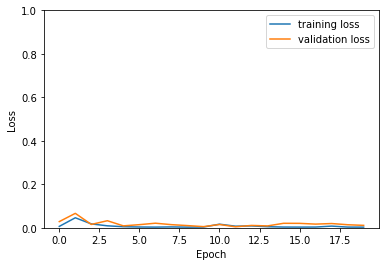

In [9]:
results=model.fit(xs_train,y_train,epochs=20, batch_size=8, validation_split=0.2,verbose=1)

en_out=model.predict(xs_test)

# Shift back for plotting

x_shift=xs_test
x_shift[:,0]=xs_test[:,0]*np.average(x_test[:,0])+np.average(x_test[:,0])
x_shift[:,1]=xs_test[:,1]*np.average(x_test[:,1])+np.average(x_test[:,1])

a_sum=np.sum(x_shift,axis=1)

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_sum, en_out,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

### Make some predictions

We can, in principle, hand the neural net a N,Z array, and predict binding energies

In [49]:
N=8
Z=8

Zs=(Z - np.average(xx[:,0])) / np.average(xx[:,0])
Ns=(N - np.average(xx[:,1])) / np.average(xx[:,1])

nucleus=np.array([[Zs,Ns]])

[[BE]] = model.predict(nucleus)

print("Binding Energy Per Nucleon: ",BE)
print("Binding Energy: ",BE*(N+Z))

Binding Energy Per Nucleon:  -103.04091
Binding Energy:  -1648.654541015625


## Save the model for posterity

Since it takes a long time to train

In [116]:
# This won't overwrite the 'real' trained github file
model.save('neuralmasses_testing.h5')
